In [1]:
%load_ext watermark
%watermark

Last updated: 2022-12-01T23:20:16.962249-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.6.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import pandas as pd

import numpy as np

import seaborn as sns

from ipywidgets import interact, FloatSlider, IntSlider

from IPython.display import display

from scipy import stats

import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances, euclidean_distances
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.cluster import hierarchy
from hdbscan import HDBSCAN

from sklearn.datasets import load_iris

sns.set(font_scale=0.7)

# Resume

https://www.kaggle.com/datasets/uciml/iris

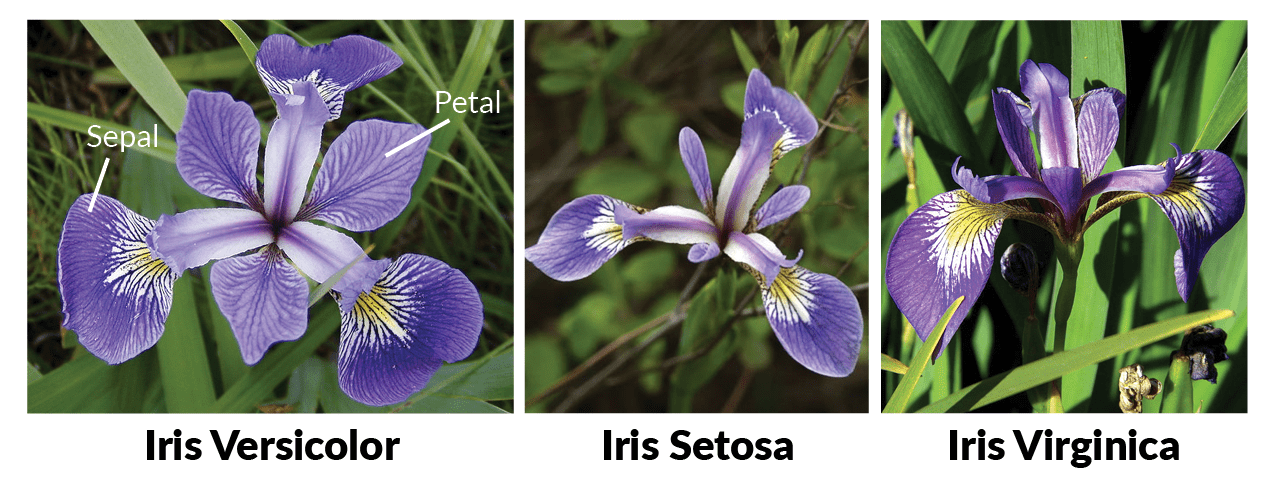

# Data Collection

In [3]:
iris = load_iris()

# As it is a clustering problem, we should not have the target variable (TARGET).
# In case of having it, it would be a classification problem.
# The target variable is not loaded to use the same classification problem as clustering.

df = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])

# Rename the columns
df.rename(columns={"sepal length (cm)": "SEPAL_LENGHT",
                   "sepal width (cm)": "SEPAL_WIDTH",
                   "petal length (cm)": "PETAL_LENGHT",
                   "petal width (cm)": "PETAL_WIDTH"}, inplace=True)

df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# Data Wrangling

Verificar los tipos de datos.

In [4]:
df.dtypes

SEPAL_LENGHT    float64
SEPAL_WIDTH     float64
PETAL_LENGHT    float64
PETAL_WIDTH     float64
dtype: object

Combinar los diferentes dataset cargados.

In [5]:
#

# Data Visualization

In [6]:
def update_datatypes_columns():
    numeric_features = df.select_dtypes(include=np.number).columns.to_list()

    continuous_features = df.select_dtypes(include=float).columns.to_list()

    discrete_features = df.select_dtypes(include=int).columns.to_list()

    categorical_features = df.select_dtypes(
        include='category').columns.to_list()

    object_features = df.select_dtypes(include='object').columns.to_list()

    bool_features = df.select_dtypes(include=bool).columns.to_list()

    date_time_features = df.select_dtypes(
        include=np.datetime64).columns.to_list()

    time_delta_features = df.select_dtypes(
        include=np.timedelta64).columns.to_list()

    display({'numeric_features': numeric_features, 'continuous_features': continuous_features,
             'discrete_features': discrete_features, 'categorical_features': categorical_features,
             'object_features': object_features, 'bool_features': bool_features,
             'date_time_features': date_time_features, 'time_delta_features': time_delta_features})

    return numeric_features, continuous_features, discrete_features, categorical_features, \
        object_features, bool_features, date_time_features, time_delta_features


numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

{'numeric_features': ['SEPAL_LENGHT',
  'SEPAL_WIDTH',
  'PETAL_LENGHT',
  'PETAL_WIDTH'],
 'continuous_features': ['SEPAL_LENGHT',
  'SEPAL_WIDTH',
  'PETAL_LENGHT',
  'PETAL_WIDTH'],
 'discrete_features': [],
 'categorical_features': [],
 'object_features': [],
 'bool_features': [],
 'date_time_features': [],
 'time_delta_features': []}

## Numerical variables

### Statistical Summary

In [7]:
df.describe()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Correlation

#### Dispersion Diagram

In [8]:
@interact(x=numeric_features,
          y=np.roll(numeric_features, -1),
          size=np.roll(numeric_features, -2))
def _(x, y, size):
    if x == y:
        sns.displot(data=df, x=x)
    else:
        sns.relplot(data=df, x=x, y=y, size=size, height=6, alpha=.5)

    plt.show()

interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

In [9]:
@interact()
def _():
    sns.pairplot(df, diag_kind='hist')
    plt.show()

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [10]:
@interact(x=numeric_features, y=categorical_features, orient=['vertical', 'horizontal'])
def _(x, y, orient):
    plt.rcParams['figure.figsize'] = (10, 6)

    orient = 'v' if orient == 'vertical' else 'h'

    if orient == 'v':
        x, y = y, x

    sns.swarmplot(data=df, x=x, y=y, orient=orient, size=3)
    plt.show()

interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

#### Pearson Correlation

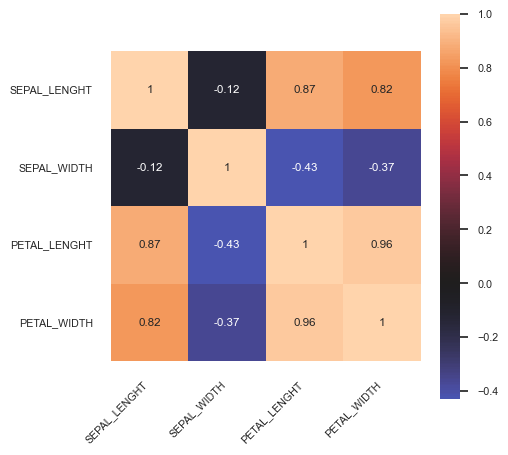

In [11]:
plt.rcParams['figure.figsize'] = (5, 5)

matrix = df.corr(method='pearson', numeric_only=True)
chart = sns.heatmap(matrix, annot=True, square=True, center=0)
chart.set_xticklabels(chart.get_xticklabels(),
                      rotation=45, horizontalalignment='right')
plt.show()

### Distributions - Histogram

In [12]:
@interact(col=numeric_features, normal=False, stat=['count', 'frequency', 'probability', 'percent', 'density'],
          cumulative=False, kde=False)
def _(col, normal, stat, cumulative, kde):
    plt.figure(figsize=(10, 5))

    # ax1 -----------------------------------------------------------------------------------
    ax1 = plt.subplot(1, 2, 1)

    if normal == False:
        sns.histplot(df, ax=ax1, x=col, multiple='stack',
                     cumulative=cumulative, kde=kde)
    else:
        sns.histplot(df, ax=ax1, x=col, stat='density')

        # Valores de la media (mu) y desviación típica (sigma) de los datos
        mu, sigma = stats.norm.fit(df[col])

        # Valores teóricos de la normal en el rango observado
        x_hat = np.linspace(min(df[col]), max(df[col]), num=100)
        y_hat = stats.norm.pdf(x_hat, mu, sigma)

        ax1.plot(x_hat, y_hat, 'r', linewidth=2, label='normal')
        ax1.legend()

    # ax2 -----------------------------------------------------------------------------------

    ax2 = plt.subplot(1, 2, 2)
    fig = sm.qqplot(df[col], fit=True, line='q', alpha=0.4, lw=2, ax=ax2)

    # ---------------------------------------------------------------------------------------

    kurtosis, skew = stats.kurtosis(df[col]), stats.skew(df[col])
    kurtosis, skew = round(kurtosis, 2), round(skew, 2)

    if skew < -1 or skew > 1:
        print(f'- La distribución está muy sesgada (skew={skew}).')
    elif -1 <= skew < -0.5 or 0.5 < skew <= 1:
        print(f'- La distribución está moderadamente sesgada (skew={skew}).')
    elif -0.5 <= skew <= 0.5:
        print(f'- La distribución es aproximadamente simétrica (skew={skew}).')

    if kurtosis < -0.5:
        print(
            f'- La distribución platicúrtica (kurtosis={kurtosis}), ', end='')
        print('existe una baja concentración de los valores en torno a su media.')
    if kurtosis > 0.5:
        print(f'- La distribución leptocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una gran concentración de los valores en torno a su media.')
    if -0.5 <= kurtosis <= 0.5:
        print(f'- La distribución mesocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una concentración normal de los valores en torno a su media.')

    plt.show()

interactive(children=(Dropdown(description='col', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PET…

### Box - Violin Plot

In [13]:
@interact(orient_h=True, violin=False)
def _(orient_h, violin):
    plt.rcParams['figure.figsize'] = (10, 3)

    if violin:
        sns.violinplot(data=df, orient=('h' if orient_h else 'v'))
    else:
        sns.boxplot(data=df, orient=('h' if orient_h else 'v'))

    plt.show()

interactive(children=(Checkbox(value=True, description='orient_h'), Checkbox(value=False, description='violin'…

In [14]:
@interact(x=numeric_features, violin=False, show_points=True)
def _(x, violin, show_points):
    plt.rcParams['figure.figsize'] = (10, 4)

    if violin:
        sns.violinplot(data=df, x=x)
    else:
        sns.boxplot(data=df, x=x)

    if show_points == True:
        sns.stripplot(data=df, x=x, color='.3', size=3)

    plt.show()

interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

Se agrupan por:
- Quintiles si la variable es continua.
- Valores originales si la variable es discreta con menos de 10 únicos valores, caso contrario se agrupa por deciles.
- Valores originales si la variable es categórica.

In [15]:
@interact(x=numeric_features+categorical_features,
          y=np.roll(numeric_features, -1),
          violin=False, show_points=True)
def _(x, y, violin, show_points):
    # The list is divided into 5 quintiles if the variable is continuous.
    if df[x].dtype == float:
        quintiles = pd.qcut(df[x], 5, duplicates='drop')
        new_df = df[y].to_frame().join(quintiles)
    # If the variable is discrete and with less than 10 different values, it is left as is, otherwise it is grouped.
    elif df[x].dtype == int:
        if df[x].unique().size > 10:
            quintiles = pd.qcut(df[x], 10, duplicates='drop')
            new_df = df[y].to_frame().join(quintiles)
        else:
            new_df = df[y].to_frame().join(df[x])
    # If the variable is categorical, it is left as is.
    elif df[x].dtype == 'category':
        new_df = df[y].to_frame().join(df[x])

    if show_points == True:
        sns.stripplot(data=df, x=x, y=y, color='.3', size=3)

    plt.rcParams['figure.figsize'] = (10, 6)

    if violin:
        sns.violinplot(x=x, y=y, data=new_df)
    else:
        sns.boxplot(x=x, y=y, data=new_df)

    sns.despine(offset=10, trim=True)

    plt.show()

interactive(children=(Dropdown(description='x', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'PETAL…

## Categorical variables

Se crean variables categóricas auxiliares a partir de las variables numéricas.

We have 2 options to group the values.
- cut: The space between the groups are equal and the frequencies of each group are different.
- qcut: The space between the groups are different and the frequencies of each group are equal.

To make containers with very different data less likely we use qcut.

In [16]:
types = ['very low', 'low', 'moderate', 'high', 'very high']

# Columns created are added to delete later.
types_column = {'TYPE_SEPAL_LENGHT': 'SEPAL_LENGHT', 'TYPE_SEPAL_WIDTH': 'SEPAL_WIDTH',
                'TYPE_PETAL_LENGHT': 'PETAL_LENGHT', 'TYPE_PETAL_WIDTH': 'PETAL_WIDTH'}

# The column SEPAL_LENGHT is divided by quintiles
df[list(types_column.keys())[0]] = pd.qcut(x=df[list(types_column.values())[0]], q=len(types),
                                           labels=types)

# The column SEPAL_WIDTH is divided by quintiles
df[list(types_column.keys())[1]] = pd.qcut(x=df[list(types_column.values())[1]], q=len(types),
                                           labels=types)

# The column PETAL_LENGHT is divided by quintiles
df[list(types_column.keys())[2]] = pd.qcut(x=df[list(types_column.values())[2]], q=len(types),
                                           labels=types)

# The column PETAL_WIDTH is divided by quintiles
df[list(types_column.keys())[3]] = pd.qcut(x=df[list(types_column.values())[3]], q=len(types),
                                           labels=types)

# You can generate as many categorical columns from numeric columns as you like.

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

df.head()

{'numeric_features': ['SEPAL_LENGHT',
  'SEPAL_WIDTH',
  'PETAL_LENGHT',
  'PETAL_WIDTH'],
 'continuous_features': ['SEPAL_LENGHT',
  'SEPAL_WIDTH',
  'PETAL_LENGHT',
  'PETAL_WIDTH'],
 'discrete_features': [],
 'categorical_features': ['TYPE_SEPAL_LENGHT',
  'TYPE_SEPAL_WIDTH',
  'TYPE_PETAL_LENGHT',
  'TYPE_PETAL_WIDTH'],
 'object_features': [],
 'bool_features': [],
 'date_time_features': [],
 'time_delta_features': []}

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH,TYPE_SEPAL_LENGHT,TYPE_SEPAL_WIDTH,TYPE_PETAL_LENGHT,TYPE_PETAL_WIDTH
0,5.1,3.5,1.4,0.2,low,very high,very low,very low
1,4.9,3.0,1.4,0.2,very low,low,very low,very low
2,4.7,3.2,1.3,0.2,very low,high,very low,very low
3,4.6,3.1,1.5,0.2,very low,moderate,very low,very low
4,5.0,3.6,1.4,0.2,very low,very high,very low,very low


### Pie Chart

In [17]:
@interact(x=categorical_features+object_features)
def _(x):
    if x == None:
        print('No existen variables discretas o categóricas.')
        return

    plt.rcParams['figure.figsize'] = (5, 5)

    labels = df[x].value_counts().index.values
    sizes = df[x].value_counts().values
    explode = np.full(df[x].value_counts().count(), 0.1)

    _, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.axis('equal')

    plt.show()

interactive(children=(Dropdown(description='x', options=('TYPE_SEPAL_LENGHT', 'TYPE_SEPAL_WIDTH', 'TYPE_PETAL_…

### Contingency Table

In [18]:
@interact(col1=categorical_features, col2=categorical_features[::-1], col3=numeric_features,
          aggfunc=['count', 'mean', 'median', 'std', 'probability'])
def _(col1, col2, col3, aggfunc):
    plt.rcParams['figure.figsize'] = (8, 8)

    if len(categorical_features) < 2:
        return

    agg_func_aux = 'count' if aggfunc == 'probability' else aggfunc
    contingency_table = df.pivot_table(values=col3, index=col1, columns=col2,
                                       aggfunc=agg_func_aux,
                                       fill_value=0).dropna(axis=0, how='all')

#     display(contingency_table)

    if aggfunc == 'probability':
        contingency_table = contingency_table.astype(float).div(contingency_table.sum(axis=1),
                                                                axis=0)
        fmt = '.2%'
    else:
        fmt = 'g'

    sns.heatmap(contingency_table, annot=True, fmt=fmt, square=True)

    plt.show()

interactive(children=(Dropdown(description='col1', options=('TYPE_SEPAL_LENGHT', 'TYPE_SEPAL_WIDTH', 'TYPE_PET…

### Statistics

In [19]:
@interact(var_1=numeric_features, var_2=numeric_features, var_3=numeric_features,
          aggfunc=['count', 'mean', 'median', 'std', 'probability'],
          group=categorical_features,
          bar_type=['vertical', 'horizontal', 'apiladas'])
def _(var_1, var_2, var_3, group, aggfunc, bar_type):
    plt.rcParams['figure.figsize'] = (10, 6)

    agg_func_aux = 'count' if aggfunc == 'probability' else aggfunc

    bars = pd.DataFrame({var_1: df.groupby(group)[var_1].agg(agg_func_aux),
                         var_2: df.groupby(group)[var_2].agg(agg_func_aux),
                         var_3: df.groupby(group)[var_3].agg(agg_func_aux)})

#     display(bars)

    if aggfunc == 'probability':
        bars = pd.DataFrame({var_1: bars[var_1].astype(float).div(bars[var_1].sum()),
                             var_2: bars[var_2].astype(float).div(bars[var_2].sum()),
                             var_3: bars[var_3].astype(float).div(bars[var_3].sum())})

    if bar_type == 'vertical':
        bars.plot.bar(rot=0, title='Barras verticales', ylabel=aggfunc)
    elif bar_type == 'horizontal':
        bars.plot.barh(title='Barras horizontales', xlabel=aggfunc)
    elif bar_type == 'apiladas':
        bars.div(bars.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, title='Barras apiladas',
                                                         ylabel=aggfunc)

    plt.show()

interactive(children=(Dropdown(description='var_1', options=('SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT', 'P…

## Temporal Trends

In [20]:
# There are no temporary variables in the dataset.

Se eliminan las columnas categóricas creadas anteriormente.

In [21]:
df.drop(types_column.keys(), axis=1, inplace=True)

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

{'numeric_features': ['SEPAL_LENGHT',
  'SEPAL_WIDTH',
  'PETAL_LENGHT',
  'PETAL_WIDTH'],
 'continuous_features': ['SEPAL_LENGHT',
  'SEPAL_WIDTH',
  'PETAL_LENGHT',
  'PETAL_WIDTH'],
 'discrete_features': [],
 'categorical_features': [],
 'object_features': [],
 'bool_features': [],
 'date_time_features': [],
 'time_delta_features': []}

# Data Cleaning

In [22]:
df.head()

,SEPAL_LENGHT,SEPAL_WIDTH,PETAL_LENGHT,PETAL_WIDTH
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [23]:
# Completely empty rows are removed.
# In case you want to delete the row if any of its values is missing, use 'any' in the 'how' parameter
# Use subset['col1', 'col2'] if you want to apply to some columns only.
df.dropna(axis=0, how='all', inplace=True)

df.drop_duplicates(keep='first', inplace=True)

df.shape

(149, 4)

## Multicollinearity

In [24]:
def vif_calc(df):
    vif_data = pd.DataFrame()
    vif_data['FEAUTURE'] = df.columns

    vif_data['VIF'] = [variance_inflation_factor(
        df.values, i) for i in range(len(df.columns))]

    return vif_data


def vif_excec(df):
    numeric_features = df.select_dtypes(include=np.number).columns.to_list()
    non_numeric_features = df.select_dtypes(
        exclude=np.number).columns.to_list()

    numeric_df, non_numeric_df = df[numeric_features], df[non_numeric_features]

    while True:
        vif_data = vif_calc(numeric_df)

        big_vif = vif_data[vif_data.VIF >= 5].sort_values(by='VIF',
                                                          ascending=False).head(1)

        if big_vif.shape[0] > 0:
            numeric_features.remove(big_vif.iloc[0]['FEAUTURE'])
            numeric_df = numeric_df[numeric_features]

            feature_vif = big_vif.iloc[0]['FEAUTURE']
            vif_value = str(big_vif.iloc[0]['VIF'])
            print(f'Removed {feature_vif} with VIF={vif_value}.')
        else:
            break

    df = numeric_df.merge(right=non_numeric_df, how='inner',
                          left_index=True, right_index=True, validate='1:1')

    return df

- Si se desea usar VIF (Variance Inflation Factor), se debe utilizar el dataframe original.
- Se hace una copia para ver su funcionamiento.
- También se puede incluir las variables generadas a partir de los datos categóricos.
- No siempre se obtienen mejores resultados aplicando VIF.

In [25]:
vif_excec(df)

# df = vif_excec(df)
# df.head()

Removed SEPAL_LENGHT with VIF=262.0147823692499.
Removed PETAL_LENGHT with VIF=61.49110307320066.


,SEPAL_WIDTH,PETAL_WIDTH
0,3.5,0.2
1,3.0,0.2
2,3.2,0.2
3,3.1,0.2
4,3.6,0.2
...,...,...
145,3.0,2.3
146,2.5,1.9
147,3.0,2.0
148,3.4,2.3


## Cardinality

In [26]:
n_records = len(df)


def duplicate_column_values(df):
    resume = pd.DataFrame(columns=['VARIABLE', 'DATA_TYPE',
                                   'MORE_COMMON_VAL', 'MORE_COMMON_QTY', 'MORE_COMMON_PERC',
                                   'LESS_COMMON_VAL', 'LESS_COMMON_QTY', 'LESS_COMMON_PERC'])

    for columna in df:
        n_per_value = df[columna].value_counts(dropna=False)
        more_common_qty = n_per_value.iloc[0]
        less_common_qty = n_per_value.iloc[-1]

        new_df = pd.DataFrame(data={'VARIABLE': [columna],
                                    'DATA_TYPE': [df[columna].dtype],
                                    'MORE_COMMON_VAL': [n_per_value.index[0]],
                                    'MORE_COMMON_QTY': [more_common_qty],
                                    'MORE_COMMON_PERC': [round(more_common_qty * 100 / (1.0 * n_records), 3)],
                                    'LESS_COMMON_VAL': [n_per_value.index[-1]],
                                    'LESS_COMMON_QTY': [less_common_qty],
                                    'LESS_COMMON_PERC': [round(less_common_qty * 100 / (1.0 * n_records), 3)]})

        resume = pd.concat([resume, new_df], ignore_index=True)

    return resume


resume = duplicate_column_values(df)
resume

,VARIABLE,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC
0,SEPAL_LENGHT,float64,5.0,10,6.711,7.9,1,0.671
1,SEPAL_WIDTH,float64,3.0,26,17.450,2.0,1,0.671
2,PETAL_LENGHT,float64,1.4,13,8.725,6.4,1,0.671
3,PETAL_WIDTH,float64,0.2,29,19.463,0.5,1,0.671


In [27]:
resume.loc[(resume.MORE_COMMON_PERC > 90.) |
           ((resume.MORE_COMMON_PERC > 25.) & (resume.MORE_COMMON_VAL.isna()))]

,VARIABLE,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC


In [28]:
df.drop(labels=[], axis=1, inplace=True)

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

{'numeric_features': ['SEPAL_LENGHT',
  'SEPAL_WIDTH',
  'PETAL_LENGHT',
  'PETAL_WIDTH'],
 'continuous_features': ['SEPAL_LENGHT',
  'SEPAL_WIDTH',
  'PETAL_LENGHT',
  'PETAL_WIDTH'],
 'discrete_features': [],
 'categorical_features': [],
 'object_features': [],
 'bool_features': [],
 'date_time_features': [],
 'time_delta_features': []}

## Outliers

In [29]:
def build_outliers_resume(df, min_zcores):
    resume = pd.DataFrame(
        columns=['VARIABLE', 'FREQUENCY', 'OUTLIER', 'DATA_TYPE'])

    for col in numeric_features:
        # zcores absoluto de cada valor de la columna seleccionada
        zcores = np.abs(stats.zscore(df[col]))

        # TODO: Probar con 1.5 luego, así funcionan los boxplots
        n_outliers = len(df[zcores > min_zcores])

        new_df = pd.DataFrame(data={'VARIABLE': [col],
                                    'FREQUENCY': [n_outliers],
                                    'OUTLIER': [False if n_outliers == 0 else True],
                                    'DATA_TYPE': [df[col].dtype]})

        resume = pd.concat([resume, new_df], ignore_index=True, axis=0)

    return resume


outliers_resume_df = build_outliers_resume(df, min_zcores=3)
outliers_resume_df

C:\Users\ereye\AppData\Local\Temp\ipykernel_19092\3331635191.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  resume = pd.concat([resume, new_df], ignore_index=True, axis=0)


,VARIABLE,FREQUENCY,OUTLIER,DATA_TYPE
0,SEPAL_LENGHT,0,False,float64
1,SEPAL_WIDTH,1,True,float64
2,PETAL_LENGHT,0,False,float64
3,PETAL_WIDTH,0,False,float64


- Se sustituyen los outliers por NaN. 
- Las columnas `discretas` se convierte automáticamente a `continuas` ya que NaN es un valor continuo.

In [30]:
def set_outlier_values(df, min_zcores):
    for col in outliers_resume_df[outliers_resume_df.OUTLIER == True].VARIABLE.values:
        zcores = np.abs(stats.zscore(df[col]))
        idx = zcores[zcores > 3].index

        df.loc[idx, col] = np.nan


set_outlier_values(df, 3)

build_outliers_resume(df, min_zcores=3)

C:\Users\ereye\AppData\Local\Temp\ipykernel_19092\3331635191.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  resume = pd.concat([resume, new_df], ignore_index=True, axis=0)


,VARIABLE,FREQUENCY,OUTLIER,DATA_TYPE
0,SEPAL_LENGHT,0,False,float64
1,SEPAL_WIDTH,0,False,float64
2,PETAL_LENGHT,0,False,float64
3,PETAL_WIDTH,0,False,float64


# Machine Learning

## Preprocess

- Se crea el `preprocess` para las variables independientes.
- Se toma en cuenta el análisis de la distribución de las variables numéricas para decidir la estrategia de imputación `[median, mean]`.

In [31]:
preprocessor_resume = pd.DataFrame(data=df.dtypes, columns=['TYPE'])
preprocessor_resume['VALUES'] = preprocessor_resume.apply(lambda x: df[x.name].unique(),
                                                          axis=1)
preprocessor_resume['VALUES_LEN'] = preprocessor_resume.apply(lambda x: len(df[x.name].unique()),
                                                              axis=1)
preprocessor_resume[['IMPUTER', 'TRANSFORMER', 'STATE']] = 'UNKNOWN'

# ------------------------------------------------------------------------------------------------------------------
preprocessor_resume.loc[[], ['IMPUTER']] = 'Mean'
preprocessor_resume.loc[[], ['IMPUTER']] = 'Mode'
preprocessor_resume.loc[['SEPAL_LENGHT', 'SEPAL_WIDTH',
                         'PETAL_LENGHT', 'PETAL_WIDTH'], ['IMPUTER']] = 'Median'
# ------------------------------------------------------------------------------------------------------------------
preprocessor_resume.loc[['SEPAL_LENGHT', 'SEPAL_WIDTH',
                         'PETAL_LENGHT', 'PETAL_WIDTH'], ['TRANSFORMER']] = 'MIX_MAX_SCALER'
preprocessor_resume.loc[[], ['TRANSFORMER']] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[[], ['TRANSFORMER']] = 'ORDINAL_ENCODER'
# ------------------------------------------------------------------------------------------------------------------
median_mix_max_scaler_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                                    ('transformer', MinMaxScaler())])

median_mix_max_scaler_features = preprocessor_resume.query(
    'IMPUTER == "Median" and TRANSFORMER == "MIX_MAX_SCALER"').index.to_list()

preprocessor_resume.loc[median_mix_max_scaler_features, ['STATE']] = 'OK'

preprocessor = ColumnTransformer(transformers=[('median_mix_max_scaler',
                                                median_mix_max_scaler_transformer, median_mix_max_scaler_features)])
# ------------------------------------------------------------------------------------------------------------------

display(preprocessor)
display(preprocessor_resume)

X = preprocessor.fit_transform(X=df)
print(f'Dimensiones de los datos: {X.shape}.')
input_dim = X.shape[1]
# del X

ColumnTransformer(transformers=[('median_mix_max_scaler',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('transformer',
                                                  MinMaxScaler())]),
                                 ['SEPAL_LENGHT', 'SEPAL_WIDTH', 'PETAL_LENGHT',
                                  'PETAL_WIDTH'])])

,TYPE,VALUES,VALUES_LEN,IMPUTER,TRANSFORMER,STATE
SEPAL_LENGHT,float64,"[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.4, 4.8, 4.3, ...",35,Median,MIX_MAX_SCALER,OK
SEPAL_WIDTH,float64,"[3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 2.9, 3.7, ...",23,Median,MIX_MAX_SCALER,OK
PETAL_LENGHT,float64,"[1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1.0, 1.9, ...",43,Median,MIX_MAX_SCALER,OK
PETAL_WIDTH,float64,"[0.2, 0.4, 0.3, 0.1, 0.5, 0.6, 1.4, 1.5, 1.3, ...",22,Median,MIX_MAX_SCALER,OK


Dimensiones de los datos: (149, 4).


## Optimal Number of Clusters

### Elbow Method

In [32]:
@interact(algorithm={'KMeans': KMeans, 'KMedoids': KMedoids})
def _(algorithm):
    distortions = []
    K = range(1, 10)

    for k in K:
        model = algorithm(n_clusters=k)
        model.fit(df)
        distortions.append(model.inertia_)

    plt.figure(figsize=(10, 5))

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Num Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    plt.show()

interactive(children=(Dropdown(description='algorithm', options={'KMeans': <class 'sklearn.cluster._kmeans.KMe…

### Hierarchical Clustering

In [33]:
# similarity_measures_imp = euclidean_distances | cosine_distances | manhattan_distances
similarity_measures_imp = euclidean_distances

similarity_measures = similarity_measures_imp(X, X)
similarity_measures_df = pd.DataFrame(similarity_measures)
similarity_measures_df

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0.000000,0.233964,0.176714,0.229424,0.053270,0.222558,0.151962,0.055902,0.334946,0.195365,...,1.170227,1.256032,1.200817,1.260533,1.286611,1.195672,1.091680,1.086375,1.149214,0.968895
1,0.233964,0.000000,0.107880,0.096425,0.274138,0.442917,0.204300,0.184707,0.146138,0.063949,...,1.181982,1.264553,1.212275,1.278346,1.310789,1.196014,1.037753,1.083907,1.178441,0.956495
2,0.176714,0.107880,0.000000,0.063141,0.200723,0.388058,0.105164,0.127898,0.160707,0.089653,...,1.218674,1.296979,1.247386,1.309112,1.336141,1.232670,1.092604,1.121476,1.195997,0.989264
3,0.229424,0.096425,0.063141,0.000000,0.253547,0.435554,0.143591,0.175900,0.107880,0.093169,...,1.213202,1.289753,1.243427,1.302808,1.331802,1.225254,1.072856,1.111932,1.191090,0.974279
4,0.053270,0.274138,0.200723,0.253547,0.000000,0.201173,0.149487,0.092476,0.359190,0.233341,...,1.190200,1.273450,1.220289,1.276876,1.300446,1.215657,1.120020,1.106939,1.159586,0.987220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.195672,1.196014,1.232670,1.225254,1.215657,1.129780,1.217622,1.189519,1.261227,1.218861,...,0.115092,0.091644,0.073755,0.152028,0.180890,0.000000,0.304837,0.136790,0.231294,0.305078
145,1.091680,1.037753,1.092604,1.072856,1.120020,1.082093,1.098681,1.073035,1.088876,1.067720,...,0.337192,0.374794,0.360864,0.414218,0.470270,0.304837,0.000000,0.240051,0.447774,0.256947
146,1.086375,1.083907,1.121476,1.111932,1.106939,1.028141,1.108227,1.078168,1.148768,1.104360,...,0.131518,0.193718,0.174138,0.211921,0.268824,0.136790,0.240051,0.000000,0.238278,0.187108
147,1.149214,1.178441,1.195997,1.191090,1.159586,1.058796,1.162589,1.146159,1.235684,1.194243,...,0.251691,0.201917,0.242877,0.207904,0.175745,0.231294,0.447774,0.238278,0.000000,0.293241


In [34]:
# method = single | complete | average | weighted | centroid | median | ward
Z = hierarchy.linkage(y=similarity_measures, method='average')
Z_df = pd.DataFrame(Z, columns=[
                    'cluster_1', 'cluster_2', 'distancia', 'cantidad_elementos (acumulados)'])
Z_df[:30]

C:\Users\ereye\AppData\Local\Temp\ipykernel_19092\1708828335.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(y=similarity_measures, method='average')


,cluster_1,cluster_2,distancia,cantidad_elementos (acumulados)
0,30.0,34.0,0.111956,2.0
1,2.0,47.0,0.122640,2.0
2,120.0,142.0,0.125608,2.0
3,28.0,39.0,0.126845,2.0
4,10.0,48.0,0.138690,2.0
5,0.0,40.0,0.165028,2.0
6,17.0,27.0,0.170637,2.0
7,19.0,46.0,0.178931,2.0
8,88.0,95.0,0.179827,2.0
9,7.0,152.0,0.196458,3.0


Cophenet coefficient: Calculates the cophenetic distances between each observation in the hierarchical clustering defined by the Z link.

In [35]:
c, coph_dist = cophenet(Z, pdist(similarity_measures))
print('{:.2f}% conservation of the original distances with respect to the clusters that have been generated'.format(c))

0.93% conservation of the original distances with respect to the clusters that have been generated


In [36]:
@interact(orientation=['top', 'right'],
          method=['average', 'single', 'complete',
                  'weighted', 'centroid', 'median', 'ward'],
          measure={'euclidean': euclidean_distances, 'cosine': cosine_distances,
                   'manhattan': manhattan_distances},
          last_p=FloatSlider(value=30, min=1, max=100, step=1))
def _(orientation, method, measure, last_p):
    if orientation == 'right':
        plt.figure(figsize=(5, 10))
        plt.xlabel('Distance')
        plt.ylabel('Sample indices')
    else:
        plt.figure(figsize=(10, 5))
        plt.xlabel('Sample')
        plt.ylabel('Distance')

    plt.title('Hierarchical Clustering Dendrogram')

    similarity_measures = measure(X, X)

    Z = hierarchy.linkage(y=similarity_measures, method=method)

    c, coph_dist = cophenet(Z, pdist(similarity_measures))
    print('{:.2f}% conservation of the original distances with respect to the clusters that have been generated'.format(c))

    dendro = hierarchy.dendrogram(Z=Z, orientation=orientation, color_threshold=0.5 * Z[-1][2],
                                  truncate_mode='lastp', p=last_p, show_leaf_counts=True, show_contracted=True)
    plt.show()

    # color_threshold: define los colores según el porcentaje multiplicado por la distancia global
    # por defecto es el 70% de la distancia global si no se define valor alguno
    # z[-1][2]): distancia del último cluster

    # Si no aparecen entre paretesis significa los valores de aquellos clusters que no han sido generados en las
    # últimas n agrupaciones (no contienen bolitas en sus lineas).
    # Si aparecen entre parentesis significa los elementos que forman parte del cluster (contienen bolitas en sus lineas).

interactive(children=(Dropdown(description='orientation', options=('top', 'right'), value='top'), Dropdown(des…

### Gap

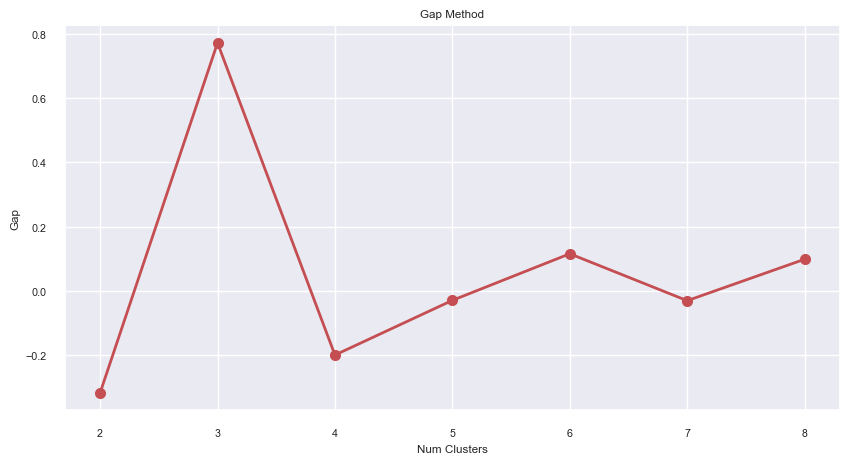

In [37]:
# Obtain the last 10 distances between points
last = Z[-10:, 2]
num_clustres = np.arange(1, len(last))  # No se toma el primer valor

# Calculate Gap
gap = np.diff(last, n=2)               # Second derivative
gap = gap[:-1]                         # Se elimina el último valor

plt.figure(figsize=(10, 5))
plt.plot(num_clustres[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)

plt.xlabel('Num Clusters')
plt.ylabel('Gap')
plt.title('Gap Method')
plt.show()

### Silhouette Coefficient

In [38]:
@interact(algorithm={'KMeans': KMeans, 'KMedoids': KMedoids},
          n_clusters=IntSlider(value=2, min=2, max=10, step=1))
def _(algorithm, n_clusters):
    plt.figure(figsize=(10, 6))
    model = algorithm(n_clusters=n_clusters)

    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X)

    plt.title('Silhouette Coefficient')
    plt.show()

interactive(children=(Dropdown(description='algorithm', options={'KMeans': <class 'sklearn.cluster._kmeans.KMe…

In [39]:
n_clusters = 3

print('From the previous methods the number of clusters is obtained.')

From the previous methods the number of clusters is obtained.


## K-Means

In [40]:
k_means = KMeans(n_clusters=n_clusters)
k_means_clusters = k_means.fit_predict(X)
k_means_clusters

C:\Users\ereye\miniconda3\envs\env39\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2])

Centroides.

In [41]:
centroides = k_means.cluster_centers_
centroides

array([[0.70726496, 0.49184149, 0.79704476, 0.82478632],
       [0.19611111, 0.63636364, 0.07830508, 0.06083333],
       [0.44166667, 0.33560606, 0.57372881, 0.54583333]])

In [42]:
centroides.shape

(3, 4)

Final inertia of the clusters.

In [43]:
k_means.inertia_

7.261399419004646

Centroid distances.

In [44]:
centroid_distances = euclidean_distances(centroides)
pd.DataFrame(centroid_distances)

,0,1,2
0,0.000000,1.175745,0.471844
1,1.175745,0.000000,0.794621
2,0.471844,0.794621,0.000000


## K-medoids

In [45]:
k_medoids = KMedoids(n_clusters=n_clusters)
k_medoids_clusters = k_medoids.fit_predict(X)
k_medoids_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

## DBSCAN

Optimal value of epsilon.

Text(0, 0.5, 'Distance')

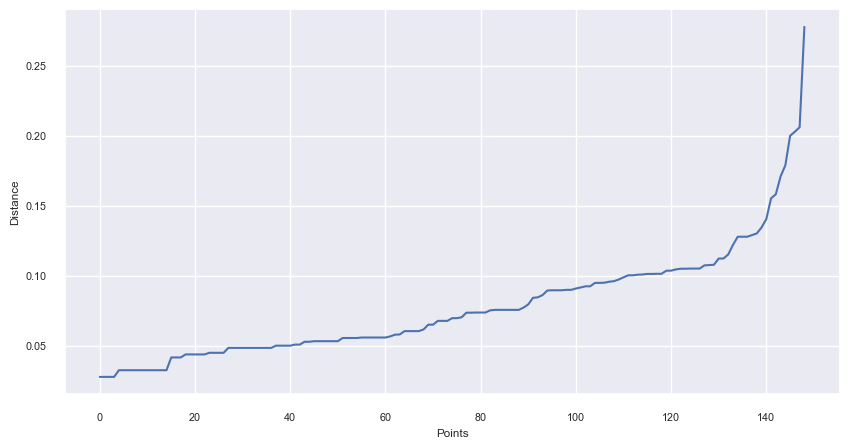

In [46]:
plt.rcParams['figure.figsize'] = (10, 5)

neighbors = NearestNeighbors(n_neighbors=4).fit(X)
distances, indices = neighbors.kneighbors(X=X, return_distance=True)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

plt.xlabel("Points")
plt.ylabel("Distance")

In [47]:
db_scan = DBSCAN(eps=0.13, min_samples=4)
db_scan_clusters = db_scan.fit_predict(X)
db_scan_clusters

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,
        1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1,
       -1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int64)

## HDBSCAN

In [48]:
hdbscan = HDBSCAN(min_cluster_size=3)
hdbscan_clusters = hdbscan.fit_predict(X)
hdbscan_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)